<h3>A04_1</h3>

In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(linewidth=120)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pi = np.pi

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Load and pre-process images

In [69]:
mydigits = []
my_x = []
yval = []
MNIST_len = 28
kernel_size = 7
kernel_size_2 = int(kernel_size/2)
gauss_sigma = 1


def gauss_2d(x,y,sigma):
    return np.exp(-(x**2+y**2)/(2*sigma**2))

def downsample(_image,_new_len):
    _sigma = gauss_sigma
    _outimage = np.zeros((_new_len,_new_len))
    n_pix=np.shape(_image)[0]
    binratio = n_pix/_new_len
    relative_coord = []
    _image = np.pad(_image,(kernel_size_2,kernel_size_2),constant_values=0)
    for i in range(_new_len):
        for j in range(_new_len):
            xcent = kernel_size_2+int(n_pix*i/_new_len)
            ycent = kernel_size_2+int(n_pix*j/_new_len)
            for i_old in range(xcent-kernel_size_2,xcent+kernel_size_2+1):
                for j_old in range(ycent-kernel_size_2,ycent+kernel_size_2+1):
                    relx = i/_new_len - (i_old-2)/n_pix
                    rely = j/_new_len - (j_old-2)/n_pix
                    _outimage[i,j] += gauss_2d(relx,rely,_sigma)*_image[i_old,j_old]
#                     _outimage[i,j] = max(_outimage[i,j],_image[i_old,j_old])

    return _outimage
    

for i in range(10):
    yval.append(i)
    #read
    image = plt.imread(f'./my_digits/{i}_hi.png')[:,:,1]
    image -= np.min(image)
    image /= np.max(image)
    image = 1-image

    #rectangularize
    shape = np.shape(image)
    xlen = shape[0]
    ylen = shape[1]
    dif = xlen-ylen
    if (dif > 0): #x > y
        padl = dif//2
        padr = dif - padl
        image = image[padl:xlen-padr,:]
    elif (dif < 0):
        padl = -dif//2
        padr = -dif - padl
        image = image[:,padl:ylen-padr]
    
    # downsample
    image = downsample(image,MNIST_len)
    image -= np.min(image)
    image /= np.max(image)
    mydigits.append(image.flatten())
    my_x.append(image)

yval = np.array(yval)
mydigits = np.array(mydigits)
my_x = np.array(my_x)
my_x = my_x.reshape(10,28,28,1)

In [70]:
def plot_digit_array(x,y, show_prediction=False):
    '''Expects a list of digits (x) and associated labels (y)'''
    
    # determine the number of rows and columns of our image array
    num_digits = x.shape[0]
    num_cols = int(np.sqrt(num_digits))
    num_rows = num_digits//num_cols + 1

    fig,ax = plt.subplots(nrows=num_rows,ncols=num_cols,sharex=True,sharey=True,
                          figsize=(num_cols,num_rows))
    
    # plot all the numbers
    for i,cax in enumerate(ax.flatten()):
        if i < num_digits:
            cax.matshow(x[i].reshape(28,28), cmap='binary')
            cax.axis('off')
            if show_prediction:
                cax.text(0.99,0.99,f'{y[i]}',horizontalalignment='right',verticalalignment='top', 
                         transform=cax.transAxes, fontsize=8, color='r')
        else:
            cax.axis('off')

Now the CNN

In [12]:
# load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# determine the properties
rows,cols = x_train[0].shape
num_classes = 10

x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

# use a built-in function to get 1-hot encoding
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)

yval_hot = keras.utils.to_categorical(yval, num_classes)

In [35]:
model = keras.Sequential(
[
    layers.Conv2D(input_shape=(rows,cols,1), kernel_size=(5, 5), filters=12,
                  activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(30, (5, 5), activation='relu'),
    layers.Dropout(0.5),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Flatten(),
    layers.Dense(30*4*4, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 12)        312       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 30)        9030      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10, 30)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 270)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 480)              

In [36]:
batch_size = 64
epochs = 10

training = model.fit(x_train,y_train_hot, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,y_test_hot))

Epoch 1/10
938/938 [==============================] - 74s 78ms/step - loss: 0.5038 - accuracy: 0.8421 - val_loss: 0.0731 - val_accuracy: 0.9844
Epoch 2/10
938/938 [==============================] - 75s 80ms/step - loss: 0.0799 - accuracy: 0.9746 - val_loss: 0.0569 - val_accuracy: 0.9877
Epoch 3/10
938/938 [==============================] - 72s 77ms/step - loss: 0.0566 - accuracy: 0.9825 - val_loss: 0.0482 - val_accuracy: 0.9894
Epoch 4/10
938/938 [==============================] - 72s 77ms/step - loss: 0.0473 - accuracy: 0.9855 - val_loss: 0.0383 - val_accuracy: 0.9902
Epoch 5/10
938/938 [==============================] - 72s 77ms/step - loss: 0.0445 - accuracy: 0.9854 - val_loss: 0.0327 - val_accuracy: 0.9905
Epoch 6/10
938/938 [==============================] - 74s 79ms/step - loss: 0.0381 - accuracy: 0.9877 - val_loss: 0.0302 - val_accuracy: 0.9919
Epoch 7/10
938/938 [==============================] - 72s 77ms/step - loss: 0.0358 - accuracy: 0.9884 - val_loss: 0.0332 - val_accuracy:

In [65]:

guesses = model(my_x)
yval_guess = np.argmax(guesses,axis=1)
mistakes = np.where(yval_guess != yval)[0]
print("Mistakes",mistakes)



[6]


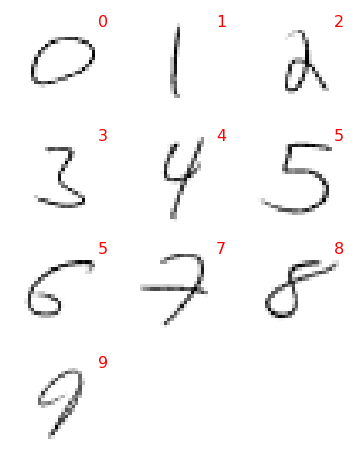

In [66]:
plot_digit_array(mydigits[idx],np.array(yval_guess)[idx],True)

My sixes look tilted, rather than re-train my model (again) I am going to pre-process it.

Mistakes: []


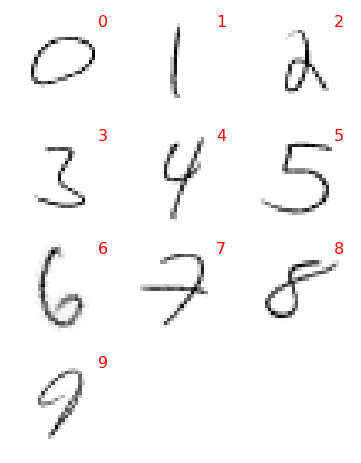

In [68]:
from scipy import ndimage

mydigits_2 = mydigits
my_x_2 = my_x
angle = 30
rotated_digit = np.abs(ndimage.rotate(my_x[6,:,:,0], angle, reshape=False)).astype(float)
rotated_digit -= np.min(rotated_digit)
rotated_digit /= np.max(rotated_digit)
my_x2[6,:,:,0]=rotated_digit
mydigits_2[6,:] = rotated_digit.reshape(784)
idx = np.arange(10)

guesses = model(my_x2)
yval_guess = np.argmax(guesses,axis=1)
mistakes = np.where(yval_guess != yval)[0]
print("Mistakes:",mistakes)
plot_digit_array(mydigits[idx],np.array(yval_guess)[idx],True)